### Validate our Environment

**Check Python version. This notebook is implemented for Python 3.5.x. Not all cells may work in other versions of Python.**

In [1]:
import platform
print(platform.python_version())

3.5.5


# Predicting Customer Churn

In this notebook you will learn how to build a predictive model with Spark machine learning API (SparkML) and deploy it for scoring in Machine Learning (ML). 

This notebook walks you through these steps:
- Build a model with SparkML API
- Save the model in the ML repository
- Create a Deployment in ML (via UI)
- Test the model (via UI)
- Test the model (via REST API)

## Step 1: Review Use Case

The analytics use case implemented in this notebook is telco churn. While it's a simple use case, it implements all steps from the CRISP-DM methodolody, which is the recommended best practice for implementing predictive analytics. 
![CRISP-DM](https://raw.githubusercontent.com/yfphoon/dsx_demo/master/crisp_dm.png)

The analytics process starts with defining the business problem and identifying the data that can be used to solve the problem. For Telco churn, we use demographic and historical transaction data. We also know which customers have churned, which is the critical information for building predictive models. In the next step, we use visual APIs for data understanding and complete some data preparation tasks. In a typical analytics project data preparation will include more steps (for example, formatting data or deriving new variables). 

Once the data is ready, we can build a predictive model. In our example we are using the SparkML Random Forrest classification model. Classification is a statistical technique which assigns a "class" to each customer record (for our use case "churn" or "no churn"). Classification models use historical data to come up with the logic to predict "class", this process is called model training. After the model is created, it's usually evaluated using another data set. 

Finally, if the model's accuracy meets the expectations, it can be deployed for scoring. Scoring is the process of applying the model to a new set of data. For example, when we receive new transactional data, we can score the customer for the risk of churn.  

We also developed a sample Python Flask application to illustrate deployment: http://predictcustomerchurn.mybluemix.net/. This application implements the REST client call to the model.

### Prerequisite:  Upgrade Pixiedust and dependencies

## **<span style="color:red"> Action Required </span>** 
** Restart Kernel after Pixiedust Upgrade **

In [2]:
!pip install --user --upgrade pixiedust py4j jinja2 pandas

Requirement already up-to-date: pixiedust in /user-home/1001/.local/lib/python3.5/site-packages (1.1.15)
Requirement already up-to-date: py4j in /user-home/1001/.local/lib/python3.5/site-packages (0.10.8.1)
Requirement already up-to-date: jinja2 in /opt/conda3/lib/python3.5/site-packages (2.10)
Requirement already up-to-date: pandas in /user-home/1001/.local/lib/python3.5/site-packages (0.24.1)
You are using pip version 18.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


![RESTART KERNEL](https://raw.githubusercontent.com/krondor/ICP4D-/master/pics/restart_kernel.png)

### Working with Notebooks

If you are new to Notebooks, here's a quick overview of how to work in this environment.

1. The notebook has 2 types of cells - markdown (text) and code. 
2. Each cell with code can be executed independently or together (see options under the Cell menu). When working in this notebook, we will be running one cell at a time because we need to make code changes to some of the cells.
3. To run the cell, position cursor in the code cell and click the Run (arrow) icon. The cell is running when you see the * next to it. Some cells have printable output.
4. Work through this notebook by reading the instructions and executing code cell by cell. Some cells will require modifications before you run them. 

## Step 2: Load customer HDFS dataset via remote Spark session

In [3]:
import dsx_core_utils
%load_ext sparkmagic.magics

# Retrieve a list of registered Hadoop Integration systems.
DSXHI_SYSTEMS = dsx_core_utils.get_dsxhi_info(showSummary=True)

Available Hadoop systems: 

  systemName  LIVYSPARK  LIVYSPARK2 imageId
0     hdp263  livyspark  livyspark2        
1     hdp265  livyspark  livyspark2        


In [4]:
# Set up sparkmagic to connect to the selected registered HI systemName above.
myConfig={
    "queue": "default",
    "driverMemory": "512M",
    "numExecutors": 1,
    "executorMemory":"512M"
}

HI_CONFIG = dsx_core_utils.setup_livy_sparkmagic(
  system="hdp263", 
  livy="livyspark2",
  imageId=None,
  addlConfig=myConfig)

# (Re-)load spark magic to apply the new configs.
%reload_ext sparkmagic.magics

sparkmagic has been configured to use https://hdp263-wsl5.fyre.ibm.com:8443/gateway/9.30.182.106/livy2/v1 
success configuring sparkmagic livy.


In [5]:
%spark cleanup
session_name = 'spark2_0205'
livy_endpoint = HI_CONFIG['LIVY']
webhdfs_endpoint = HI_CONFIG['WEBHDFS']
%spark add -s $session_name -l python -u $livy_endpoint

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
12,application_1549042673081_0016,pyspark,idle,Link,Link,✔


SparkSession available as 'spark'.


In [6]:
%spark info

Info for running Spark:
    Sessions:
        Name: spark2_0205	Session id: 12	YARN id: application_1549042673081_0016	Kind: pyspark	State: idle
	Spark UI: http://hdp263-wsl2.fyre.ibm.com:8088/proxy/application_1549042673081_0016/
	Driver Log: http://hdp263-wsl5.fyre.ibm.com:8042/node/containerlogs/container_e02_1549042673081_0016_01_000001/dsxhi
    Session configs:
        {'queue': 'default', 'conf': {'spark.yarn.appMasterEnv.HI_UTILS_PATH': '/user/dsxhi/environments/pythonAddons/hi_core_utils.zip'}, 'proxyUser': 'dsxhi', 'numExecutors': 1, 'executorMemory': '512M', 'driverMemory': '512M'}



In [7]:
%%spark -s $session_name
import socket
print("Remote livy session driver: {}".format(socket.gethostname()))

Remote livy session driver: hdp263-wsl4.fyre.ibm.com

In [8]:
%%spark
sc.version

u'2.2.0.2.6.3.0-235'

In [9]:
sc.version

'2.2.1'

In [10]:
%%spark -s $session_name -c sql
show tables

,database,tableName,isTemporary
0,default,del2,False
1,default,ext_customer,False
2,default,out_0208,False


In [9]:
%%spark?

In [11]:
%%spark

file_customer = "hdfs:///data/demo/customer/enhanced_customer.csv"
df_cust = spark.read.format("org.apache.spark.sql.execution.datasources.csv.CSVFileFormat").option("header", "true").option("inferSchema", "true").load(file_customer)
df_cust.printSchema()

print("Total number of customer dataset row count: {}\n".format(df_cust.count()))

root
 |-- PHASE: string (nullable = true)
 |-- ID: integer (nullable = true)
 |-- LONGDISTANCE: integer (nullable = true)
 |-- INTERNATIONAL: integer (nullable = true)
 |-- LOCAL: integer (nullable = true)
 |-- DROPPED: integer (nullable = true)
 |-- PAYMETHOD: string (nullable = true)
 |-- LOCALBILLTYPE: string (nullable = true)
 |-- LONGDISTANCEBILLTYPE: string (nullable = true)
 |-- USAGE: integer (nullable = true)
 |-- RATEPLAN: integer (nullable = true)
 |-- GENDER: string (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- CHILDREN: integer (nullable = true)
 |-- ESTINCOME: double (nullable = true)
 |-- CAROWNER: string (nullable = true)
 |-- AGE: double (nullable = true)

Total number of customer dataset row count: 2066

### <font color="blue">B. </font> Load customer churn HDFS dataset via remote Spark session:

In [12]:
%%spark

file_churn = "hdfs:///data/demo/churn/churn.csv"
df_churn = spark.read.format("org.apache.spark.sql.execution.datasources.csv.CSVFileFormat").option("header", "true").option("inferSchema", "true").load(file_churn)
df_churn.printSchema()

print("Total number of churn dataset row count: {}\n".format(df_churn.count()))


root
 |-- ID: integer (nullable = true)
 |-- CHURN: string (nullable = true)

Total number of churn dataset row count: 2066

If the first step ran successfully (you saw the output), then continue reviewing the notebook and running each code cell step by step. Note that not every cell has a visual output. The cell is still running if you see a * in the brackets next to the cell. 

If the first step didn't finish successfully, check with the instructor. 

## Step 3: Merge Files
While merging files, making sure that you are using the remote connected data - customer(df1 or other version) and churn data. The name of the enhanced customer data table may be different. You should make sure that the name is consistent with the name when importing. 

In [13]:
%%spark

df_data = df_cust.join(df_churn,df_cust['ID']==df_churn['ID']).select(df_cust['*'],df_churn['CHURN'])

print("Total number of customer and churn combined dataset row count: {}\n".format(df_data.count()))

Total number of customer and churn combined dataset row count: 2066

## Step 4: Data Prep
A typical data scientist workflow may involve lots of data prep.  This is a simple example of this process, we can rename columns, define data types, or otherwise manipulate data elements.  


In [15]:
## Schema Data Type Transformation 
# Change data type example:
#data = data.withColumn('ID', data['ID'].cast('int'))
#data = data.withColumn('USAGE', data['USAGE'].cast('Decimal(5,0)'))

## Step 5: Data understanding

Data preparation and data understanding are the most time-consuming tasks in the data mining process. The data scientist needs to review and evaluate the quality of data before modeling.

Visualization is one of the ways to reivew data.

The Brunel Visualization Language is a highly succinct and novel language that defines interactive data visualizations based on tabular data. The language is well suited for both data scientists and business users. 
More information about Brunel Visualization: https://github.com/Brunel-Visualization/Brunel/wiki

Try Brunel visualization here: http://brunel.mybluemix.net/gallery_app/renderer

In [14]:
%%spark -s $session_name -o data
data = df_data

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2066 entries, 0 to 2065
Data columns (total 18 columns):
PHASE                   2066 non-null object
ID                      2066 non-null int64
LONGDISTANCE            2066 non-null int64
INTERNATIONAL           2066 non-null int64
LOCAL                   2066 non-null int64
DROPPED                 2066 non-null int64
PAYMETHOD               2066 non-null object
LOCALBILLTYPE           2066 non-null object
LONGDISTANCEBILLTYPE    2066 non-null object
USAGE                   2066 non-null int64
RATEPLAN                2066 non-null int64
GENDER                  2066 non-null object
STATUS                  2066 non-null object
CHILDREN                2066 non-null int64
ESTINCOME               2066 non-null float64
CAROWNER                2066 non-null object
AGE                     2066 non-null float64
CHURN                   2066 non-null object
dtypes: float64(2), int64(8), object(8)
memory usage: 290.6+ KB


In [16]:
from autovizwidget.widget.utils import display_dataframe
display_dataframe(data)

/opt/conda/lib/python3.5/site-packages/autovizwidget/widget/utils.py:50: FutureWarning:

A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.



Output()

AutoVizWidget()


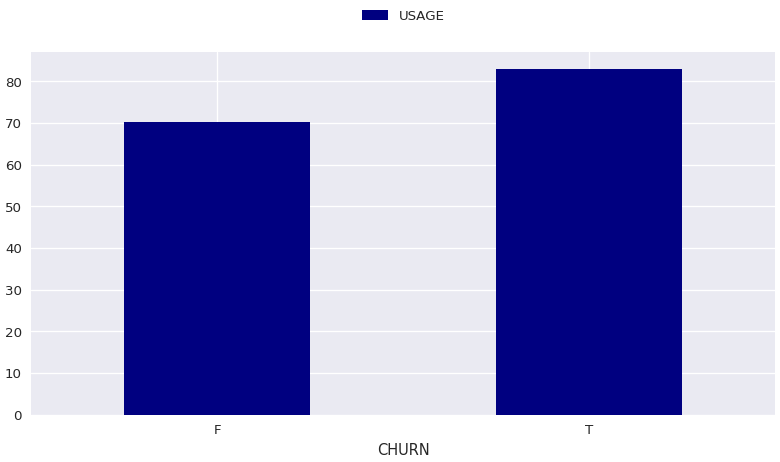

In [17]:
from pixiedust.display import *
display(data)

## Step 6: Build the Spark pipeline and the Random Forest model
"Pipeline" is an API in SparkML that's used for building models.
Additional information on SparkML: https://spark.apache.org/docs/2.0.2/ml-guide.html

In [18]:
%%spark
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
import numpy

# Prepare string variables so that they can be used by the decision tree algorithm
# StringIndexer encodes a string column of labels to a column of label indices
SI1 = StringIndexer(inputCol='GENDER', outputCol='GenderEncoded')
SI2 = StringIndexer(inputCol='STATUS',outputCol='StatusEncoded')
SI3 = StringIndexer(inputCol='CAROWNER',outputCol='CarOwnerEncoded')
SI4 = StringIndexer(inputCol='PAYMETHOD',outputCol='PaymethodEncoded')
SI5 = StringIndexer(inputCol='LOCALBILLTYPE',outputCol='LocalBilltypeEncoded')
SI6 = StringIndexer(inputCol='LONGDISTANCEBILLTYPE',outputCol='LongDistanceBilltypeEncoded')
SI7 = StringIndexer(inputCol='PHASE',outputCol='PhaseEncoded')
labelIndexer = StringIndexer(inputCol='CHURN', outputCol='label').fit(df_data)

# Pipelines API requires that input variables are passed in  a vector
assembler = VectorAssembler(inputCols=["GenderEncoded", "StatusEncoded", "CarOwnerEncoded", "PaymethodEncoded", "LocalBilltypeEncoded", \
                                       "LongDistanceBilltypeEncoded", "PhaseEncoded", "CHILDREN", "ESTINCOME", "AGE", "LONGDISTANCE", "INTERNATIONAL", "LOCAL",\
                                      "DROPPED","USAGE","RATEPLAN"], outputCol="features")

# instantiate the algorithm, take the default settings
rf=RandomForestClassifier(labelCol="label", featuresCol="features")

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)

pipeline = Pipeline(stages=[SI1,SI2,SI3,SI4,SI5,SI6,SI7,labelIndexer, assembler, rf, labelConverter])

# Split data into train and test datasets
train, test = df_data.randomSplit([0.7,0.3], seed=6)
train.cache()
test.cache()

# Build models
model = pipeline.fit(train)

model.transform(test)

DataFrame[PHASE: string, ID: int, LONGDISTANCE: int, INTERNATIONAL: int, LOCAL: int, DROPPED: int, PAYMETHOD: string, LOCALBILLTYPE: string, LONGDISTANCEBILLTYPE: string, USAGE: int, RATEPLAN: int, GENDER: string, STATUS: string, CHILDREN: int, ESTINCOME: double, CAROWNER: string, AGE: double, CHURN: string, GenderEncoded: double, StatusEncoded: double, CarOwnerEncoded: double, PaymethodEncoded: double, LocalBilltypeEncoded: double, LongDistanceBilltypeEncoded: double, PhaseEncoded: double, label: double, features: vector, rawPrediction: vector, probability: vector, prediction: double, predictedLabel: string]

In [19]:
%%spark -s $session_name -o test_local
test_local = test
print(type(test))
print(type(test_local))

<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>

## Step 7: Score the test data set

In [20]:
%%spark -s $session_name

results = model.transform(test)
results=results.select(results["ID"],results["CHURN"],results["label"],results["predictedLabel"],results["prediction"],results["probability"])
results.show(6)

+---+-----+-----+--------------+----------+--------------------+
| ID|CHURN|label|predictedLabel|prediction|         probability|
+---+-----+-----+--------------+----------+--------------------+
|  6|    F|  0.0|             F|       0.0|[0.89564720115218...|
| 14|    F|  0.0|             F|       0.0|[0.94814005265572...|
| 18|    F|  0.0|             F|       0.0|[0.81772150065880...|
| 21|    F|  0.0|             F|       0.0|[0.58192994876721...|
| 22|    F|  0.0|             F|       0.0|[0.64440750619622...|
| 35|    T|  1.0|             F|       0.0|[0.58831793453656...|
+---+-----+-----+--------------+----------+--------------------+
only showing top 6 rows

## Step 8: Model Evaluation 

In [21]:
%%spark
from pyspark.ml.evaluation import BinaryClassificationEvaluator

print('Precision model = {:.2f}.'.format(results.filter(results.label == results.prediction).count() / float(results.count())))

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label", metricName="areaUnderROC")
print('Area under ROC curve = {:.2f}.'.format(evaluator.evaluate(results)))

Precision model = 0.89.
Area under ROC curve = 0.88.

We have finished building and testing a predictive model. The next step is to deploy it for real time scoring. 

## Step 9: Save Model in ML repository

In [22]:
%%spark -s $session_name

import os
hi_utils_lib = os.getenv("HI_UTILS_PATH", "/user/dsxhi/environments/pythonAddons/hi_core_utils.zip")
sc.addPyFile("hdfs://{}".format(hi_utils_lib))

import hi_core_utils
print(hi_core_utils.write_model_to_hdfs(model=model, model_name='churn_model_02082019'))

{'path': 'hdfs:///user/dsxhi/.dsxhi/models/churn_model_02082019/1/model', 'version': 1, 'name': 'churn_model_02082019', 'latest_version': 1}

In [23]:
print(webhdfs_endpoint)
model_local = dsx_core_utils.load_model_from_hdfs(webhdfs_endpoint, model_name="churn_model_02082019")

https://hdp263-wsl5.fyre.ibm.com:8443/gateway/9.30.182.106/webhdfs/v1
Model loaded from hdfs:///user/dsxhi/.dsxhi/models/churn_model_02082019/1/model.tar.gz


In [24]:
print(type(test_local))
test_local.head(5)

<class 'pandas.core.frame.DataFrame'>


,PHASE,ID,LONGDISTANCE,INTERNATIONAL,LOCAL,DROPPED,PAYMETHOD,LOCALBILLTYPE,LONGDISTANCEBILLTYPE,USAGE,RATEPLAN,GENDER,STATUS,CHILDREN,ESTINCOME,CAROWNER,AGE,CHURN
0,Adult,6,29,0,45,0,CH,FreeLocal,Standard,75,2,M,M,2,29616.0,N,49.426667,F
1,Adult,14,5,0,23,0,CH,Budget,Intnl_discount,28,1,F,M,2,52004.8,N,25.140000,F
2,Adult,18,26,0,32,0,CC,Budget,Intnl_discount,58,1,M,M,1,75004.5,N,64.800000,F
3,Adult,21,20,0,13,0,CC,Budget,Standard,34,3,M,M,0,19749.3,N,60.366667,F
4,Adult,22,9,0,38,0,CC,Budget,Standard,48,2,M,S,1,57626.9,Y,43.906667,F


In [25]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

spark.version

'2.2.1'

In [26]:
df_test = spark.createDataFrame(test_local)
type(df_test)

pyspark.sql.dataframe.DataFrame

In [27]:
from dsx_ml.ml import save

model_name = 'churn_model_02082019'
save(name = model_name,
     model = model_local,
     algorithm_type = 'Classification',
     test_data = df_test)

Using TensorFlow backend.


{'path': '/user-home/1001/DSX_Projects/ThinkConf_ML/models/churn_model_02082019/1',
 'scoring_endpoint': 'https://dsxl-api/v3/project/score/Python35/spark-2.2/ThinkConf_ML/churn_model_02082019/1'}

## Step 10: Test Saved Model with Test UI

1. Save the notebook and select **Project** --> **Assets** --> **Models** 
2. Under **Models**, find and click into your saved model. 
4. Click the **Real-time Score** tab to test the model. You can use the following data for testing: <br/>
`Phase='Adult', ID=99, LongDistance=68, International=50, Local=100, Dropped=0, Paymethod=CC, LocalBilltype=Budget, LongDistanceBilltype=Intnl_discount, Usage=334, RatePlan=3, Gender=M, Status=S, Chidren=0, EstIncome=60000, CarOwner=Y, Age=34`

The results of the test is displayed as follows:<br/>
<img style="float: left;" src="https://github.com/Linda-Techie/ThinkConf_2019/blob/master/img/model_testing.png?raw=true" alt="Test API" width=800 />

## Step 11:  Test model with a REST API call (Optional)

This step demonstrates an "internal REST API" call to test the model (for an unpublished model). Notice that we are using DSX variables for the model endpoint and token. See documentation for external REST call syntax. An exernal REST call will have a different end point and will require authentication. 

In [28]:
json_payload = [{
    "PHASE":"Adult",
    "ID":999,
    "GENDER":"F",
    "STATUS":"M",
    "CHILDREN":2.0,
    "ESTINCOME":77551.100000,
    "CAROWNER":"Y",
    "AGE":33,
    "LONGDISTANCE":20.530000,
    "INTERNATIONAL":0.000000,
    "LOCAL":41.890000,
    "DROPPED":1.000000,
    "PAYMETHOD":"CC",
    "LOCALBILLTYPE":"Budget",
    "LONGDISTANCEBILLTYPE":"Standard",
    "USAGE":62.420000,
    "RATEPLAN":2.000000
}]

## **<span style="color:red"> Action Required </span>** 
Change the *scoring_endpoint* to the value that's shown as the *scoring_endpoint* afer running Save to ML repository function (see **Step 9**), for example *'scoring_endpoint': 'https://dsxl-api/v3/project/score/Python35/spark-2.2/ThinkConf_ML/churn_model_01312019/2'*. 

In [29]:
import requests, json
from pprint import pprint

#scoring_endpoint = 'https://dsxl-api/v3/project/score/Python35/spark-2.2/ThinkConf_ML/Customer_Churn_ML_model_LL/1'
scoring_endpoint = 'https://dsxl-api/v3/project/score/Python35/spark-2.2/ThinkConf_ML/churn_model_02082019/1'
        
header_online = {'Content-Type': 'application/json', 'Authorization':os.environ['DSX_TOKEN']}

response_scoring = requests.post(scoring_endpoint, json=json_payload, headers=header_online)


In [30]:
prediction = response_scoring.json()['object']['output']['predictions'][0]
print ('Prediction = {}'.format(prediction))
probabilities = response_scoring.json()['object']['output']['probabilities'][0]
print ('Probabilities = {}'.format(probabilities))
if prediction == 'F':
    print('Prediction = False')
    print('Probability = {0:.2f}'.format(probabilities[0]*100))
elif prediction == 'T':
    print('Prediction = True')
    print('Probability = {0:.2f}%'.format(probabilities[1]*100))
else:
    print('Probability ERROR')

Prediction = F
Probabilities = [0.8975438748792557, 0.1024561251207442]
Prediction = False
Probability = 89.75


### Summary

You have finished working on this hands-on lab. In this notebook you created a model using SparkML API, deployed it in  Machine Learning service for online (real time) scoring and tested it using a test client. 


<b>Created by</b> **Sidney Phoon**, **Elena Lowery** and **Rui Fan**
<br/>
yfphoon@us.ibm.com<br/>
elowery@us.ibm.com<br/>
rui.fan@ibm.com
Created Date: May29, 2018

<b>Modified by</b> **Vish Kamat** and **Linda Liu**
<br/>
vkamat@us.ibm.com<br/>
linda.liu@us.ibm.com<br/>
Modified Date: Jan. 23, 2019


In [37]:
%spark cleanup

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>